In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd
import skforecast

print(skforecast.__version__)

/home/joaquin/Documents/GitHub/skforecast
0.18.0


+ evidently no tiene la opcion de hacer un fit y almacenar internamente los estadisticos, por lo que hay que hacer el run con los datos de entrenamiento y luego con los nuevos
  
+ La ide a de nannyml se ajusta mas a lo nuestro, ya que permite fit. Ademas, en el entrenamiento utiliza tanto X, como y. Mientras que en el test, asume que no se conoce y.

In [2]:
from skforecast.datasets import fetch_dataset, show_datasets_info
from skforecast.recursive import ForecasterRecursive
from sklearn.ensemble import HistGradientBoostingRegressor
from skforecast.drift_detection import PopulationDriftDetector, PopulationDriftDetector


from evidently import Report
from evidently.presets import DataDriftPreset
import stumpy
import numpy as np


In [3]:
data = fetch_dataset('bike_sharing')
data.head(3)

╭───────────────────────────────── bike_sharing ──────────────────────────────────╮
│ Description:                                                                    │
│ Hourly usage of the bike share system in the city of Washington D.C. during the │
│ years 2011 and 2012. In addition to the number of users per hour, information   │
│ about weather conditions and holidays is available.                             │
│                                                                                 │
│ Source:                                                                         │
│ Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.   │
│ https://doi.org/10.24432/C5W894.                                                │
│                                                                                 │
│ URL:                                                                            │
│ https://raw.githubusercontent.com/skforecast/skforecast-                        │
│ datasets/main/data/bike_sharing_dataset_clean.csv                               │
│                                                                                 │
│ Shape: 17544 rows x 11 columns                                                  │
╰─────────────────────────────────────────────────────────────────────────────────╯

,holiday,workingday,weather,temp,atemp,hum,windspeed,users,month,hour,weekday
date_time,,,,,,,,,,,
2011-01-01 00:00:00,0.0,0.0,clear,9.84,14.395,81.0,0.0,16.0,1,0,5
2011-01-01 01:00:00,0.0,0.0,clear,9.02,13.635,80.0,0.0,40.0,1,1,5
2011-01-01 02:00:00,0.0,0.0,clear,9.02,13.635,80.0,0.0,32.0,1,2,5


In [16]:
data_train = data.iloc[: len(data)//2]
data_new  = data.iloc[len(data)//2 :]
print(f'Train: {data_train.shape}, Test: {X_new.shape}')

forecaster = ForecasterRecursive(
    regressor = HistGradientBoostingRegressor(),
    lags      = 10
)


data_train['weather'] = data_train['weather'].astype('category')
data_new['weather'] = pd.Categorical(data_new['weather'], categories=data_new['weather'].cat.categories)

Train: (8772, 11), Test: (8762, 20)


AttributeError: Can only use .cat accessor with a 'category' dtype

# NannyML

In [5]:
import nannyml as nml

In [6]:
detector = nml.UnivariateDriftCalculator(
    column_names=X_train.columns.tolist(),
    timestamp_column_name="date_time",  # optional if you have time
    #chunk_size=500,                      # adjust depending on your data size
    chunk_period='M',                  # optional if you have time
    categorical_methods=['chi2', 'jensen_shannon'],
    continuous_methods=['kolmogorov_smirnov', 'jensen_shannon'],
)
detector.fit(reference_data=X_train.reset_index())
results = detector.calculate(data=X_new.reset_index())

In [7]:
drift_df = results.filter(period='analysis').to_df(multilevel=True)
drift_df[['chunk', 'temp']]

chunk                                               \
      chunk                                                
        key chunk_index start_index end_index start_date   
0   2012-01           0           0       721 2012-01-01   
1   2012-02           1         722      1417 2012-02-01   
2   2012-03           2        1418      2161 2012-03-01   
3   2012-04           3        2162      2881 2012-04-01   
4   2012-05           4        2882      3625 2012-05-01   
5   2012-06           5        3626      4345 2012-06-01   
6   2012-07           6        4346      5089 2012-07-01   
7   2012-08           7        5090      5833 2012-08-01   
8   2012-09           8        5834      6553 2012-09-01   
9   2012-10           9        6554      7297 2012-10-01   
10  2012-11          10        7298      8017 2012-11-01   
11  2012-12          11        8018      8761 2012-12-01   

                                                         temp                  \
                                           kolmogorov_smirnov                   
                        end_date    period              value upper_threshold   
0  2012-01-31 23:59:59.999999999  analysis           0.501171        0.942814   
1  2012-02-29 23:59:59.999999999  analysis           0.490375        0.942814   
2  2012-03-31 23:59:59.999999999  analysis           0.241098        0.942814   
3  2012-04-30 23:59:59.999999999  analysis           0.225686        0.942814   
4  2012-05-31 23:59:59.999999999  analysis           0.430370        0.942814   
5  2012-06-30 23:59:59.999999999  analysis           0.492460        0.942814   
6  2012-07-31 23:59:59.999999999  analysis           0.662577        0.942814   
7  2012-08-31 23:59:59.999999999  analysis           0.628525        0.942814   
8  2012-09-30 23:59:59.999999999  analysis           0.433927        0.942814   
9  2012-10-31 23:59:59.999999999  analysis           0.253005        0.942814   
10 2012-11-30 23:59:59.999999999  analysis           0.481324        0.942814   
11 2012-12-31 23:59:59.999999999  analysis           0.476888        0.942814   

                                                                          \
                          jensen_shannon                                   
   lower_threshold  alert          value upper_threshold lower_threshold   
0             None  False       0.545816        0.862007            None   
1             None  False       0.531784        0.862007            None   
2             None  False       0.373737        0.862007            None   
3             None  False       0.452563        0.862007            None   
4             None  False       0.531164        0.862007            None   
5             None  False       0.542286        0.862007            None   
6             None  False       0.676435        0.862007            None   
7             None  False       0.645424        0.862007            None   
8             None  False       0.509535        0.862007            None   
9             None  False       0.471720        0.862007            None   
10            None  False       0.567773        0.862007            None   
11            None  False       0.543619        0.862007            None   

           
           
    alert  
0   False  
1   False  
2   False  
3   False  
4   False  
5   False  
6   False  
7   False  
8   False  
9   False  
10  False  
11  False

In [8]:
# figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='drift')
# figure.show()

# figure = results.filter(column_names=results.categorical_column_names, methods=['chi2']).plot(kind='drift')
# figure.show()

# figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='distribution')
# figure.show()

# figure = results.filter(column_names=results.categorical_column_names, methods=['chi2']).plot(kind='distribution')
# figure.show()

In [9]:
# For chunked analysis
detector = PopulationDriftDetector(
    chunk_size='ME',               # Monthly chunks
    threshold=0.99                 # 5% threshold for empirical distribution
)
detector.fit(X_train)
drift_df_chunked = detector.predict(X_new)
drift_df_chunked

,chunk,chunk_start,chunk_end,feature,ks_statistic,chi2_statistic,jensen_shannon,threshold_ks,threshold_chi2,threshold_js,reference_range,is_out_of_range,drift_ks_statistic,drift_chi2_statistic,drift_js,drift_detected
0,0,2012-01-01 22:00:00,2012-01-31 23:00:00,lag_1,0.051542,NaN,0.123377,0.519577,NaN,0.533789,"(1.0, 651.0)",False,False,False,False,False
1,1,2012-02-01 00:00:00,2012-02-29 23:00:00,lag_1,0.046331,NaN,0.126490,0.519577,NaN,0.533789,"(1.0, 651.0)",False,False,False,False,False
2,2,2012-03-01 00:00:00,2012-03-31 23:00:00,lag_1,0.209707,NaN,0.176757,0.519577,NaN,0.533789,"(1.0, 651.0)",True,False,False,False,False
3,3,2012-04-01 00:00:00,2012-04-30 23:00:00,lag_1,0.249985,NaN,0.205079,0.519577,NaN,0.533789,"(1.0, 651.0)",True,False,False,False,False
4,4,2012-05-01 00:00:00,2012-05-31 23:00:00,lag_1,0.301604,NaN,0.240991,0.519577,NaN,0.533789,"(1.0, 651.0)",True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,7,2012-08-01 00:00:00,2012-08-31 23:00:00,weekday,0.029769,NaN,0.040195,0.760242,NaN,0.612513,"(0, 6)",False,False,False,False,False
236,8,2012-09-01 00:00:00,2012-09-30 23:00:00,weekday,0.045500,NaN,0.034776,0.760242,NaN,0.612513,"(0, 6)",False,False,False,False,False
237,9,2012-10-01 00:00:00,2012-10-31 23:00:00,weekday,0.056571,NaN,0.040195,0.760242,NaN,0.612513,"(0, 6)",False,False,False,False,False
238,10,2012-11-01 00:00:00,2012-11-30 23:00:00,weekday,0.027300,NaN,0.037125,0.760242,NaN,0.612513,"(0, 6)",False,False,False,False,False


In [10]:
drift_df_chunked.query('feature == "temp"')

,chunk,chunk_start,chunk_end,feature,ks_statistic,chi2_statistic,jensen_shannon,threshold_ks,threshold_chi2,threshold_js,reference_range,is_out_of_range,drift_ks_statistic,drift_chi2_statistic,drift_js,drift_detected
156,0,2012-01-01 22:00:00,2012-01-31 23:00:00,temp,0.501171,NaN,0.462258,0.699467,NaN,0.660558,"(0.8200000000000001, 39.36)",False,False,False,False,False
157,1,2012-02-01 00:00:00,2012-02-29 23:00:00,temp,0.490375,NaN,0.452586,0.699467,NaN,0.660558,"(0.8200000000000001, 39.36)",False,False,False,False,False
158,2,2012-03-01 00:00:00,2012-03-31 23:00:00,temp,0.241098,NaN,0.333616,0.699467,NaN,0.660558,"(0.8200000000000001, 39.36)",False,False,False,False,False
159,3,2012-04-01 00:00:00,2012-04-30 23:00:00,temp,0.225686,NaN,0.388006,0.699467,NaN,0.660558,"(0.8200000000000001, 39.36)",False,False,False,False,False
160,4,2012-05-01 00:00:00,2012-05-31 23:00:00,temp,0.430370,NaN,0.450727,0.699467,NaN,0.660558,"(0.8200000000000001, 39.36)",False,False,False,False,False
161,5,2012-06-01 00:00:00,2012-06-30 23:00:00,temp,0.492460,NaN,0.460328,0.699467,NaN,0.660558,"(0.8200000000000001, 39.36)",True,False,False,False,False
162,6,2012-07-01 00:00:00,2012-07-31 23:00:00,temp,0.662577,NaN,0.571469,0.699467,NaN,0.660558,"(0.8200000000000001, 39.36)",True,False,False,False,False
163,7,2012-08-01 00:00:00,2012-08-31 23:00:00,temp,0.628525,NaN,0.545748,0.699467,NaN,0.660558,"(0.8200000000000001, 39.36)",False,False,False,False,False
164,8,2012-09-01 00:00:00,2012-09-30 23:00:00,temp,0.433927,NaN,0.435903,0.699467,NaN,0.660558,"(0.8200000000000001, 39.36)",False,False,False,False,False
165,9,2012-10-01 00:00:00,2012-10-31 23:00:00,temp,0.253005,NaN,0.414495,0.699467,NaN,0.660558,"(0.8200000000000001, 39.36)",False,False,False,False,False


In [11]:
drift_df_chunked.query('drift_detected')

,chunk,chunk_start,chunk_end,feature,ks_statistic,chi2_statistic,jensen_shannon,threshold_ks,threshold_chi2,threshold_js,reference_range,is_out_of_range,drift_ks_statistic,drift_chi2_statistic,drift_js,drift_detected
120,0,2012-01-01 22:00:00,2012-01-31 23:00:00,holiday,0.037037,NaN,0.062045,0.036288,NaN,0.101563,"(0.0, 1.0)",False,True,False,False,True
130,10,2012-11-01 00:00:00,2012-11-30 23:00:00,holiday,0.037221,NaN,0.062302,0.036288,NaN,0.101563,"(0.0, 1.0)",False,True,False,False,True
155,11,2012-12-01 00:00:00,2012-12-31 23:00:00,weather,NaN,160.840786,0.151983,NaN,138.66325,0.351711,"(nan, nan)",False,False,True,False,True
205,1,2012-02-01 00:00:00,2012-02-29 23:00:00,month,0.838165,NaN,0.744911,0.915060,NaN,0.744333,"(1, 12)",False,False,False,True,True
215,11,2012-12-01 00:00:00,2012-12-31 23:00:00,month,0.915088,NaN,0.737723,0.915060,NaN,0.744333,"(1, 12)",False,True,False,False,True


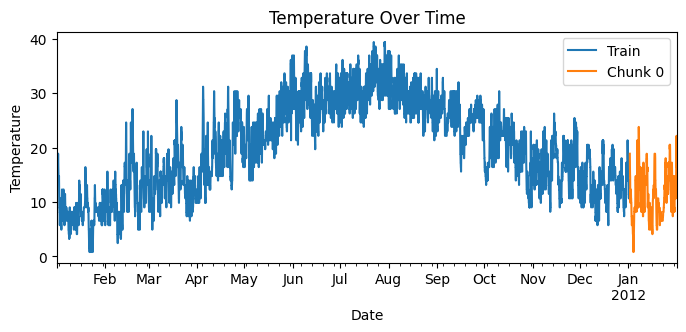

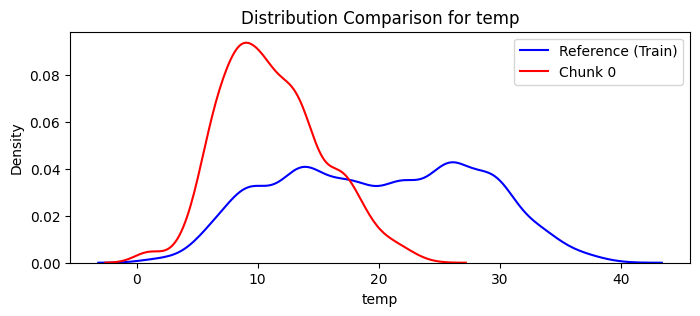

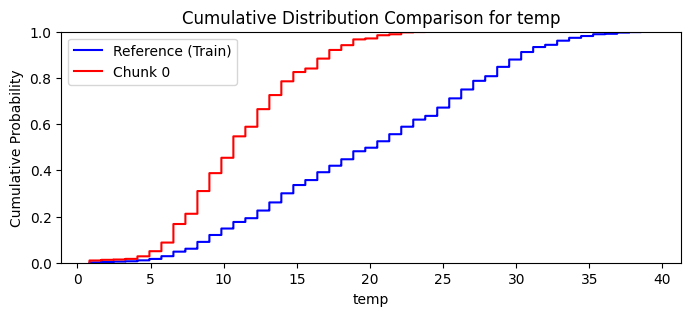

<Figure size 800x300 with 0 Axes>

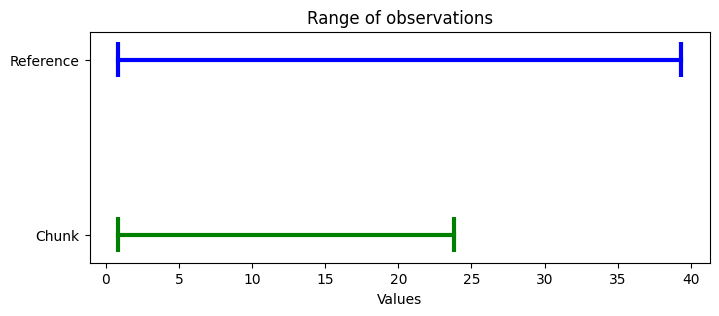

In [12]:
from matplotlib import pyplot as plt

# Plot time series
fig, ax = plt.subplots(figsize=(8, 3))
chunck_start = '2012-01-01 22:00:00'
chunck_end = '2012-01-31 23:00:00'
X_train.loc[:, 'temp'].plot(ax=ax, label='Train')
X_new.loc[chunck_start:chunck_end, 'temp'].plot(ax=ax, label='Chunk 0')
ax.set_title('Temperature Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.legend()

# Compare distributions using kdeplot
import seaborn as sns
feature = 'temp'
chunk_data = X_new.loc[chunck_start:chunck_end, feature]
ref_data = X_train[feature]
plt.figure(figsize=(8, 3))
sns.kdeplot(ref_data, label='Reference (Train)', color='blue')
sns.kdeplot(chunk_data, label='Chunk 0', color='red')
plt.title(f'Distribution Comparison for {feature}')
plt.xlabel(feature)
plt.ylabel('Density')
plt.legend()
plt.show()

# Compare cumulative distributions
plt.figure(figsize=(8, 3))
sns.ecdfplot(ref_data, label='Reference (Train)', color='blue')
sns.ecdfplot(chunk_data, label='Chunk 0', color='red')
plt.title(f'Cumulative Distribution Comparison for {feature}')
plt.xlabel(feature)
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

# Visual comparison of ranges with violin plot
plt.figure(figsize=(8, 3))
min_reference = ref_data.min()
max_reference = ref_data.max()
min_chunk = chunk_data.min()
max_chunk = chunk_data.max()

plt.figure(figsize=(8, 3))
plt.plot([min_reference, max_reference], [0, 0], color='blue', linewidth=3)
plt.vlines([min_reference, max_reference], -0.1, 0.1, color='blue', linewidth=3)
plt.plot([min_chunk, max_chunk], [1, 1], color='green', linewidth=3)
plt.vlines([min_chunk, max_chunk], 0.9, 1.1, color='green', linewidth=3)
plt.yticks([0, 1], ['Reference', 'Chunk'])
plt.xlabel("Values")
plt.title("Range of observations")
plt.gca().invert_yaxis()
plt.show();


/tmp/ipykernel_16198/14169242.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['dataset', feature])


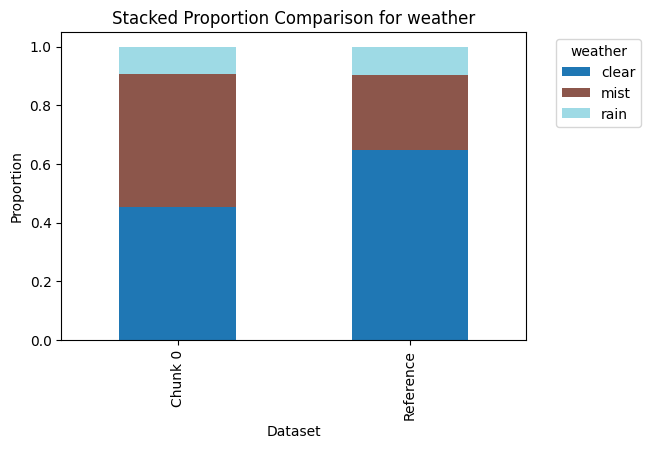

In [13]:
# Plot to compare distrubution of two categorical features
# ==============================================================================
feature = 'weather'
chunck_start = '2012-12-01 00:00:00'
chunck_end = '2012-12-31 23:00:00'
# Combine reference and chunk into one DataFrame
df = pd.concat([
    pd.DataFrame({feature: X_train[feature], 'dataset': 'Reference'}),
    pd.DataFrame({feature: X_new.loc[chunck_start:chunck_end, feature], 'dataset': 'Chunk 0'})
])

df_counts = (
    df.groupby(['dataset', feature])
      .size()
      .unstack(fill_value=0)  # categories become columns
)
df_props = df_counts.div(df_counts.sum(axis=1), axis=0)  # row-wise normalization

ax = df_props.plot(kind='bar', stacked=True, figsize=(6, 4), colormap='tab20')
plt.title(f'Stacked Proportion Comparison for {feature}')
plt.ylabel('Proportion')
plt.xlabel('Dataset')
plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Stympy

In [14]:
# import pandas as pd
# import numpy as np
# import stumpy
# import matplotlib.pyplot as plt

# def find_most_similar_subsequence(long_series: pd.Series, query: pd.Series):
#     """
#     Finds the subsequence in a pandas Series most similar to the query Series.
    
#     Parameters:
#         long_series (pd.Series): Original time series with datetime index.
#         query (pd.Series): Short query series with datetime index.
        
#     Returns:
#         best_index (int): Starting index of the best match in long_series.
#         best_distance (float): Distance of the best match.
#         best_subsequence (pd.Series): Matched subsequence as a pandas Series with original datetime index.
#     """
#     long_values = long_series.values.astype(float)
#     query_values = query.values.astype(float)
    
#     m = len(query_values)
    
#     # Compute distance profile using MASS
#     distance_profile = stumpy.mass(query_values, long_values, normalize=False)
    
#     best_index = np.argmin(distance_profile)
#     best_distance = distance_profile[best_index]
    
#     best_subsequence = long_series.iloc[best_index:best_index + m]
    
#     # Compute correlation (match quality)
#     segment_values = best_subsequence.values
#     segment_norm = (segment_values - np.mean(segment_values)) / np.std(segment_values)
#     match_quality = np.corrcoef(query_values, segment_norm)[0, 1]
    
#     return best_index, best_distance, best_subsequence, match_quality

# # Example with pandas Series
# long_series = X_train["temp"]
# #query = X_new.loc[chunck_start:chunck_end, 'temp']
# query = X_train["temp"].iloc[-1000:-500].copy()
# # Find most similar subsequence
# index, dist, segment, quality = find_most_similar_subsequence(long_series, query)
# print(f'Best match starts at index: {index}, Distance: {dist:.4f}, Match Quality (Correlation): {quality:.4f}')

# # Plot
# plt.figure(figsize=(12, 5))
# plt.plot(long_series.index, long_series.values, label='Original Series', color='blue')
# plt.plot(segment.index, segment.values, label='Best Match', color='red', linewidth=2)
# # Align query for visualization
# #aligned_query = query.values + segment.values.mean() - query.values.mean()
# # plt.plot(segment.index, aligned_query, label='Query (aligned)', color='green', linestyle='--')
# plt.plot(segment.index, query, label='Query (aligned)', color='green', linestyle='--')
# plt.title('Time Series Subsequence Matching with Datetime Index')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.show()


In [15]:
# import plotly.graph_objects as go

# # Example with pandas Series
# long_series = X_train["temp"]
# #query = X_new.loc[chunck_start:chunck_end, 'temp']
# query = X_train["temp"].iloc[-1000:-500].copy().iloc[::-1]
# # Find most similar subsequence
# index, dist, segment, quality = find_most_similar_subsequence(long_series, query)
# print(f'Best match starts at index: {index}, Distance: {dist:.4f}, Match Quality (Correlation): {quality:.4f}')

# # Plot using Plotly
# fig = go.Figure()

# # Add original series
# fig.add_trace(go.Scatter(
#     x=long_series.index,
#     y=long_series.values,
#     mode='lines',
#     name='Original Series',
#     line=dict(color='blue')
# ))

# # Add best match
# fig.add_trace(go.Scatter(
#     x=segment.index,
#     y=segment.values,
#     mode='lines',
#     name='Best Match',
#     line=dict(color='red', width=2)
# ))

# # Add query (aligned)
# fig.add_trace(go.Scatter(
#     x=segment.index,
#     y=query,
#     mode='lines',
#     name='Query (aligned)',
#     line=dict(color='green', dash='dash')
# ))

# # Update layout
# fig.update_layout(
#     title='Time Series Subsequence Matching with Datetime Index',
#     xaxis_title='Date',
#     yaxis_title='Value',
#     width=1200,
#     height=500
# )

# fig.show()